### Task : A binary classifier to forecast if a vessel in the pacific polygon (P) will go through the Panama Canal in the next 30 days.

Approach: 

1. Data cleaning and Analysis: The data was loaded, checked for missing values, number of vessels, number of daily position recordings for each ship. Additionally I also looked up for the meaning of each categorical variable.                       size variable - Cape size: largest dry cargo ships. They are too large to transit the Suez Canal or Panama Canal ( These ships were removed after verifying it doesnt pass through the canal based on the dataset too)
      PMX: Assumed to be Panamax type 
      VLOC: Very large Ore Carriers which are also supposed to be large vessesls.
      Because there is no dimentions mentioned for each of these ships, it could not be possible to directly eliminate them as       not passing through Panama due to their size. If dimensions of each ship were available, a rule based classification can       be acheived as a priliminary filtering.
      Similarly for the Variable StatusLDC, I checked the meaning of each status where ballast would simply mean the vessel is not loaded and ladden is that it is loaded. I choose to keep both variables and use it as a dummy variable as it could impact the speed and direction of the vessel. 


2. Prepare the target and independent variables for the model: 
    The target variable is created by checking if the relative distance is less than 30 Kms from the Panama Canal and if the date corresponding to that row is within 30 days of the start date of the journey.
    For the set of independent variables, the lat and long columns are removed, date columns too and the categorical variables are one-hot encoded. Since the model being fit is a  deep learning model, it is capable of variable selection by adjusting the weights of the model hence, no variable selection is done. Although the correlations between the variables are checked using a plot.


3. Evaluation metric: the model is evaluated using Mathew's correlation co-efficient (MCC). This is because Accuracy is not the right metric as the data is imbalanced. It takes into account true and false positives and negatives and is generally regarded as a balanced measure which can be used even if the classes are of very different sizes.  A coefficient of +1 represents a perfect prediction, 0 no better than random prediction and −1 indicates total disagreement between prediction and observation. Also the ROC curve is plotted for the selected threshold which gives a AUC of 0.96 which is an indication of a robust classifer.


4. Model Formation: The a 1 layer LSTM model is constructed after the data is transformed into the required 3D format for model input. Here the input data is the variables created based on the daily position measurements for the first 10 days of the journey in order to forecast if the vessel will reach panama canal on the 30th day. Before reaching the decision to consider the 1st 10 days of data, model was also built with input data as the first days measurements to predict the 30th day's status of passing(1) or not passing (0) the panama canal. This yeilded a Mathew's correlation co-efficient of negative values and 0.The current model gives a MCC of 0.89 which is closer to 1. This means that the model can almost perfectly predict for this imbalanced dataset.


5. Future Work:



     a. Additional Features: Additional features can be obtained such as weather, wind direction and also use the detination column which is not being used in this code due to time constraints in cleaning it. This could add more precision in the prediction. Variables like Course Over Ground (COG) and Speed Over Ground(SOG) which are usually recording for a vessel could also be used.
     
     
     b. Multiple Model: Currently I have fit a minimalistic LSTM model due to resource constraints. LSTM model with multiple layers can be created and paramaters can be tuned. Also additonal binary classification models can be trained such as RandomForest, XGBoost, KNN classifer( KNN classifer has been shown to give good results for route prediction problems based on my research and I intend to use it for this problem in the future) and compare the results of each of these models to choose the best one.


#### Assumptions:
1. while analysing the dataset, it was found that few recordings were not recorded everday. A gap of a few days were shown. It is assumed that this is due to connectivity issues and imputing or foward filling will distort the data. Hence it is assumed to be taken as a continuous series.

2. While Analysing the polygon zones, it was found that there were vessels that go from polygon CP to P and P to CP through the Panama Canal. Since CP is within P, it is assumed that both the directions mentioned above still mean that the vessel is moving from P through the panama canal.

3. We would require first few days of recordings in order to classify the vessels to be passing through the canal or not in the next 30 days. Which is why a time window is used.

In [1]:
# Load the required Packages

import numpy as np 
import pandas as pd 
import datetime
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Read the data and perform priliminary data quality checks

In [2]:
df_pan = pd.read_csv("exoPanama.csv", parse_dates=['date'])
df_pan.head()

C:\Users\sindh\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Column1,imo,date,latitude,longitude,destination,bearing,size,zone,statusLDC,draft
0,6964309.0,9300362.0,2011-12-26,11.123148,-74.294449,PTODRUMM OND,NaN,CAPE,True,ballast,9.8
1,1077437.0,8600595.0,2011-12-28,29.482538,-89.690895,SW PASS,NaN,PMX,True,ballast,7.3
2,1889858.0,9041021.0,2011-12-28,29.606493,-89.874352,NEWORLEANS,NaN,PMX,True,ballast,8.5
3,3515800.0,9146950.0,2011-12-28,30.114050,-90.984749,NOLA,NaN,PMX,True,laden,11.9
4,4601273.0,9213791.0,2011-12-28,11.120633,-74.286934,PDRUMMOND,NaN,PMX,True,ballast,7.6


In [3]:
df_pan.describe()
# Drop rows with all Na values
df_pan = df_pan.dropna(how = 'all')
df_pan.shape
df_pan.tail()

,Column1,imo,date,latitude,longitude,destination,bearing,size,zone,statusLDC,draft
565597,8639066.0,9364758.0,2017-07-17,12.3123,-72.0064,PUERTO BOLIVAR,NaN,PMX,True,ballast,6.5
565598,8800823.0,9374208.0,2017-07-17,50.6944,-161.7198,KALAMA USA,83.98,PMX,False,ballast,7.2
565599,8803069.0,9374210.0,2017-07-17,49.3000,-123.0734,CA VAN,NaN,PMX,False,ballast,6.9
565600,8922073.0,9381172.0,2017-07-17,-32.5974,-60.7689,SAN LORANZO,NaN,PMX,False,ballast,7.1
565601,8931319.0,9381213.0,2017-07-17,12.2569,-71.9601,CO PBO,NaN,PMX,True,ballast,8.5


In [4]:
# Prediction is for the next 30 days. Hence each ship has to have at least 30 days of recordings.
# hence keep only ships with more than 30 days of records.

In [4]:
df_pan.groupby(['imo'])['date'].count().describe()

count    3601.000000
mean      157.068037
std       157.127327
min         1.000000
25%        53.000000
50%       117.000000
75%       218.000000
max      1943.000000
Name: date, dtype: float64

In [5]:
# There are 3601 ships being tracked
print(df_pan.groupby(['imo'])['date'].count().shape)
# Remove ships that have less than 30 records
imo_no = (df_pan.groupby(['imo'])['date'].count() >= 30)

df_pan_clean1 = df_pan[df_pan['imo'].isin(imo_no[imo_no.values == True].index)]

(3601,)


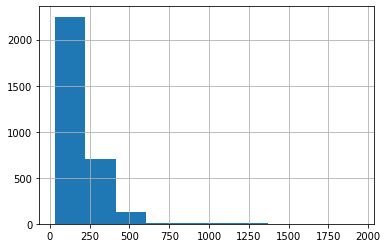

In [6]:
df_pan_clean1.groupby(['imo'])['date'].count().hist()

In [7]:
# Check for missing values
len(df_pan_clean1) - df_pan_clean1.count()
# The two columns have missing values
# The destination column needs to be cleaned as it has many special characters and non standard format of location names.
# It can be later used to derive the destination lat and long values to get the total distance between any two points.
# This is not done at the moment due to paucity of time.
# bearing can be calculated

Column1             0
imo                 0
date                0
latitude            0
longitude           0
destination      1687
bearing        185225
size                0
zone                0
statusLDC           0
draft               0
dtype: int64

# Calculate relative distance from Panama
Determining the distance from each lat long to the lat long of Panama Canal as it will determine the arrival day and thus determine if the ship crossed Panama Canal.

In [8]:
# To find distance between 2 points on the Earth
from math import radians, sqrt , asin

def haversine(df, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    
    lon1=np.array(list((map(radians,df['longitude']))))
    lat1=np.array(list(map(radians,df['latitude'])))
    lon2, lat2 = list(map(radians, [pan_long, pan_lat]))

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [9]:
#Location of Panama canal
# Source : https://www.latlong.net/place/panama-canal-panama-27609.html
pan_lat=9.080000
pan_long=-79.680000
df_pan_clean1['Distance_From_Panama_kms']=haversine(df_pan_clean1,pan_long,pan_lat)

C:\Users\sindh\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [10]:
df_pan_clean1['Relative_lat']=df_pan_clean1.latitude - pan_lat
df_pan_clean1['Relative_long']=df_pan_clean1.longitude - pan_long

C:\Users\sindh\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\sindh\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


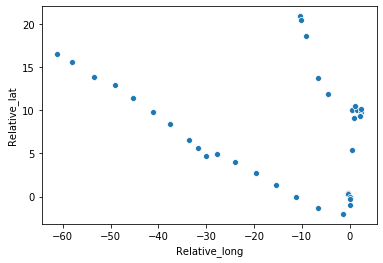

In [11]:
# Visualizing the location of the vessel at each point until it reaches the Canal
import matplotlib.pyplot as plt
import seaborn as sb
# Here (0,0) is Panama Canal
sb.scatterplot(x='Relative_long',y='Relative_lat',data=df_pan_clean1[df_pan_clean1.imo == 7621932])
plt.show()

In [12]:
df_pan_clean1.shape

(557768, 14)

## Create bearings and distance between the two points to later calculate speed of the vessel

In [13]:
df_pan_clean1['Lat_radians']=df_pan_clean1['latitude'].apply(radians)
df_pan_clean1['Long_radians']=df_pan_clean1['longitude'].apply(radians)

C:\Users\sindh\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\sindh\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [14]:
# The index column is sorted based on the dates and hence will be useful in keeping the time series order in place
df_pan_clean1 = df_pan_clean1.set_index(['Column1'])
df_pan_clean1.sort_index(inplace=True)
#df_pan_clean1.drop('Bearing_new',axis=1,inplace=True)
df_pan_clean1['Fwd_Bearing_new']=''
df_pan_clean1['Back_bearing_new']=''
df_pan_clean1['Distance_Travelled_from_previous_point']=''
df_pan_clean1.tail()

,imo,date,latitude,longitude,destination,bearing,size,zone,statusLDC,draft,Distance_From_Panama_kms,Relative_lat,Relative_long,Lat_radians,Long_radians,Fwd_Bearing_new,Back_bearing_new,Distance_Travelled_from_previous_point
Column1,,,,,,,,,,,,,,,,,,
21106558.0,9804564.0,2017-06-23,51.6108,-145.1546,FANGCHENG,-64.62,PMX,False,laden,14.9,7536.264563,42.5308,-65.4746,0.900778,-2.533426,,,
21106559.0,9804564.0,2017-06-24,52.9189,-151.9928,FANGCHENG,-70.00,PMX,False,laden,14.9,8020.933105,43.8389,-72.3128,0.923609,-2.652775,,,
21106560.0,9804564.0,2017-06-25,53.8759,-159.7530,FANGCHENG,-75.24,PMX,False,laden,14.9,8543.171953,44.7959,-80.0730,0.940312,-2.788216,,,
21106561.0,9804564.0,2017-06-26,54.3893,-166.6190,FANGCHENG,-79.97,PMX,False,laden,14.9,8990.208738,45.3093,-86.9390,0.949272,-2.908050,,,
21106562.0,9804564.0,2017-06-27,53.9824,-174.2890,FANGCHENG,-92.05,PMX,False,laden,14.9,9491.018589,44.9024,-94.6090,0.942171,-3.041917,,,


In [17]:
import pyproj
geodesic = pyproj.Geod(ellps='WGS84')
df_pan_clean1['Fwd_Bearing_new'],df_pan_clean1['Back_bearing_new'],df_pan_clean1['Distance_Travelled_from_previous_point']=np.where(df_pan_clean1.imo.shift(-1)==df_pan_clean1.imo,geodesic.inv(list(df_pan_clean1['Lat_radians']),list(df_pan_clean1['Long_radians']),list(df_pan_clean1['Lat_radians'].shift(-1)),list(df_pan_clean1['Long_radians'].shift(-1)),radians=False),np.NaN)

# Create time variables to get the number of days from the start of trip

In [18]:
# Get the starting date of journey for each ship
start_date =df_pan_clean1.groupby('imo').date.agg({'date_start': 'first'})
# Merge this with the current dataset.
df_time = df_pan_clean1.merge(start_date, left_on='imo', right_on='imo')
# Create column to find the day difference
df_time['day_diff']= df_time.sort_values(['date']).groupby('imo')['date'].diff()
# Create time difference between start date and each of the proeeding days.
df_time['total_time']= df_time.date - df_time.date_start

C:\Users\sindh\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  


In [19]:
from datetime import datetime  
from datetime import timedelta 
df_time['back_30d'] = df_time.date - timedelta(days=30) 
df_time['after_30d'] = df_time.date + timedelta(days=30) 

In [21]:
# Create a target column that identifies if the distance from panama is less than 30kms 
# and also check if the start date was less than 30 days ago
df_time['target'] = 0
for index, row in df_time.iterrows():
    if (row['Distance_From_Panama_kms'] < 30.0) & (row['back_30d'] <= row['date_start']) :
        df_time.target[index] = 1
    else:
        df_time.target[index] = 0

# Number of ships that pass are
sum(df_time.groupby('imo')['target'].sum())
# We also see that a single ship has passed multiple times

291

In [22]:
# Separate the ships that did not pass theough the Panama canal in order to create the target column
ppass = (df_time.groupby('imo')['target'].sum() != 0)
df_pan_pass = df_time[df_time['imo'].isin(ppass[ppass.values == True].index)]
df_pan_nopass = df_time[df_time['imo'].isin(ppass[ppass.values == False].index)]
print(df_pan_pass.shape)
print(df_pan_nopass.shape) 

# It is known that the CAPE size ships dont pass through the Panama canal for sure. 
# Hence we can remove all the CAPE size ships in the nopass dataframe
# Source : http://maritime-connector.com/wiki/capesize/
df_pan_nopass = df_pan_nopass[df_pan_nopass['size'] != 'CAPE']
print(df_pan_nopass.shape)

(54169, 24)
(503599, 24)
(400722, 24)


In [24]:
# prepare the target column in the right format
pass_ships = df_pan_pass.groupby(['imo'])['target'].sum()
nopass_ships = df_pan_nopass.groupby(['imo'])['target'].sum()

pass_ships['y'] = 1
nopass_ships['y'] = 0

# Target columns
y_col = pass_ships.append(nopass_ships)

for i in range(len(y_col)):
    if y_col[i] > 0:
        y_col[i] = 1
        
# Append the X columns from the split datasets 
X = df_pan_pass.append(df_pan_nopass)
# The calculated bearing values and the ones present in the dataset dont match.
# This could be because the original bearings was calculated w.r.t the destination instead of the next point.
# Hence we will use both the bearing values
# For the missing values in the original dataset forward fill the values as the missing values are less than 80%
X.bearing = X.groupby(['imo'])['bearing'].ffill()
X.bearing = X.bearing.fillna(0)

# Check correlation
t is observed that no two variables have correlation greater than 0.5 and hence no multicollienarity

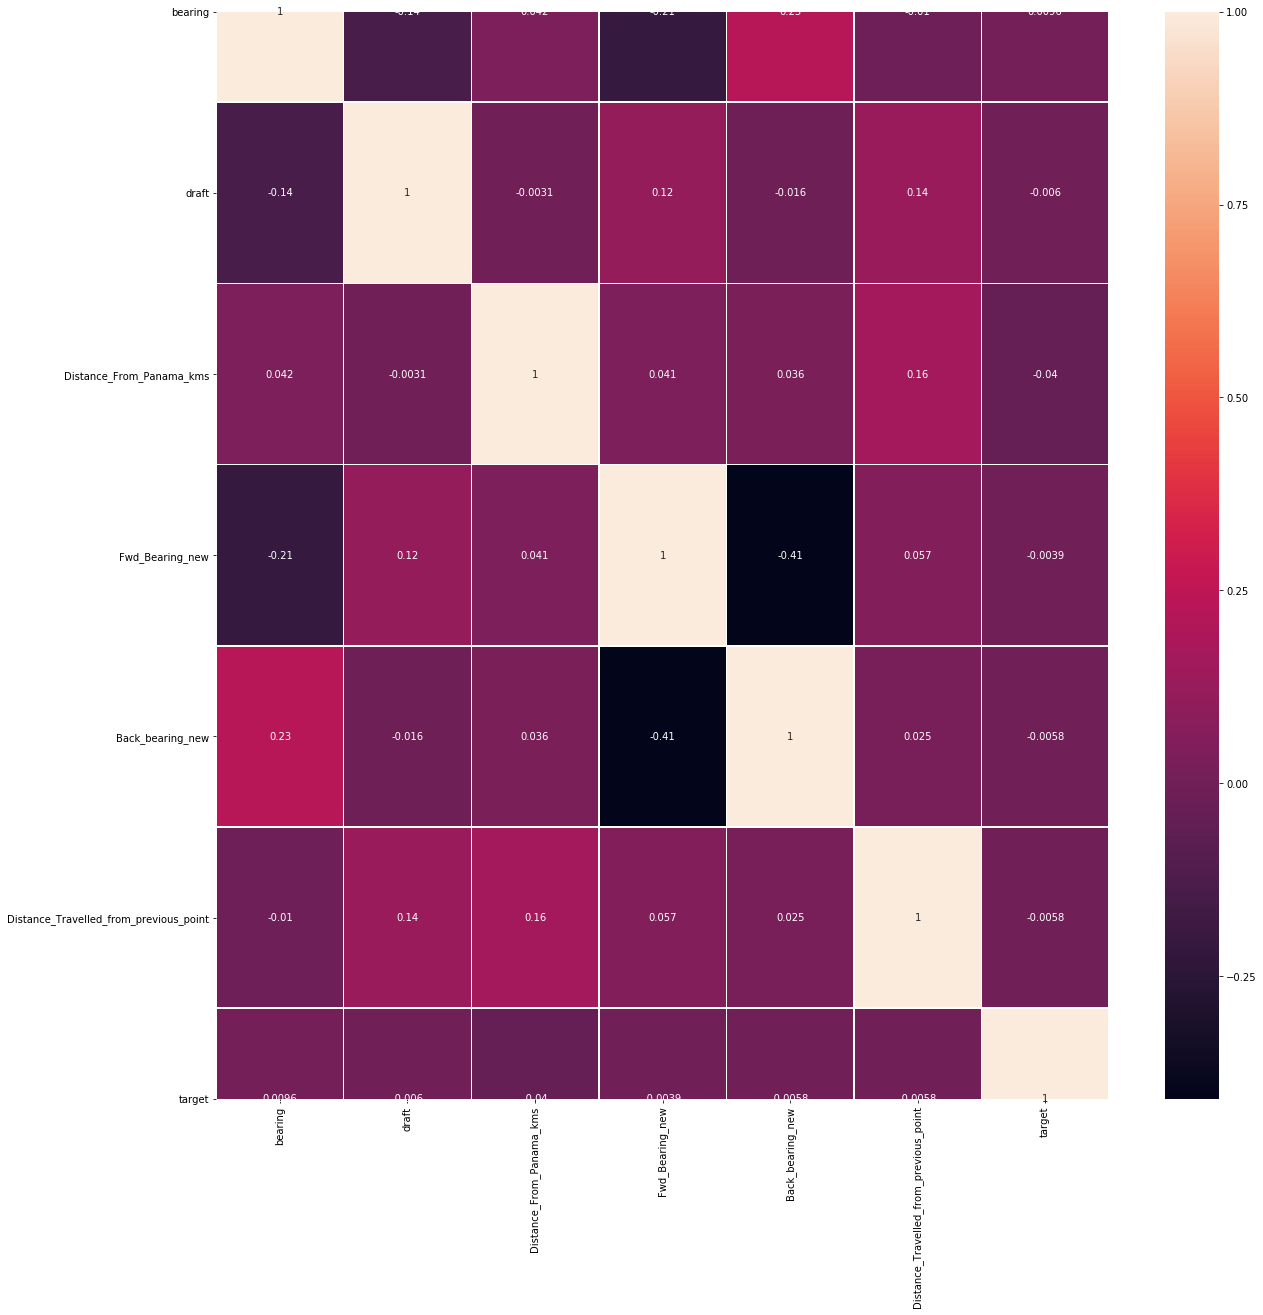

In [25]:
# Removing non numeric and non relevant variables
df1 = X[['bearing',
       'draft', 'Distance_From_Panama_kms',
       'Fwd_Bearing_new', 'Back_bearing_new',
       'Distance_Travelled_from_previous_point', 'date_start', 'day_diff',
       'total_time', 'target']]

cr = df1.corr()

fig, ax = plt.subplots(figsize=(20,20))         
sns.heatmap(cr, annot = True, linewidths =0.5, ax = ax)
plt.show()

## Convert categorical variables to dummy variables

In [42]:
X_sub = X[['imo', 'bearing', 'size', 'zone', 'statusLDC', 'draft',
       'Distance_From_Panama_kms', 'total_time']]
# Convert categorical columns to dummy variables 
X_sub = pd.get_dummies(X_sub, columns=['size','statusLDC'])
X_sub['zone'] = X_sub['zone'].map({True: 1 , False: 0})

# Convert days in type time to integer
X_sub.total_time = X_sub.total_time.dt.days
X_sub = X_sub.set_index(['imo'])

In [43]:
# Combine the X and Y varibles 
df_final = X_sub.merge(y_col, right_index= True, left_index= True)
df_final.shape

(454891, 12)

In [44]:
# Save the dataset
df_final.to_csv('final_dataset.csv')

# Prepare dataset for Modeling

In [29]:
from math import sqrt
from numpy import concatenate
#from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
 
# convert series to supervised learning
def series_to_supervised(data , df_cols, n_in= 1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in df_cols]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (col)) for col in df_cols]
        else:
            names += [('%s(t+%d)' % (col, lag)) for col in df_cols]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

Using TensorFlow backend.


In [45]:
# normalize features
values = df_final.values
df_cols = df_final.columns

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [36]:
# # Prepare the dataset for each IMO
# ship_ids=df_final.index.unique()
# df_cols = df_final.columns
# all_vessels = []

# for ship_id in ship_ids:
#     temp=df_final.loc[df_final.index == ship_id]
#     values = temp.values

#     scaler = MinMaxScaler(feature_range=(0, 1))
#     scaled = scaler.fit_transform(values)
#     ref_df = series_to_supervised(scaled, df_cols, 30, 1)
#     all_vessels.append(ref_df)

# del(values)
# del(ref_df)
# del(scaled)

# df_final = pd.concat(all_vessels)
# del(all_vessels)
# df_final.shape
# sum(df_final['target(t)'])

In [46]:
# get the names of the columns 10 timesteps after the start
# This will be used to subset the columns from the reframed dataframe
cols, names = list(), list()
for i in range(30, 0, -1):
        cols.append(df_final.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in df_cols]

names_new = names[:120]
names_new.append('target(t)')

# frame as supervised learning
# Get the first 30 days location details of the ship
reframed = series_to_supervised(scaled, df_cols, 30, 1)
reframed.head()

# Select only the first 10 time window and the 30th target
new_reframed = reframed[names_new]
new_reframed.shape

(454861, 121)

In [47]:
# Split the data into 3D format
# split into train and test sets
# Since it is timeseires, data is split while keeping the order of datasets the same
data_values = new_reframed.values
train_size = int(len(data_values) * 0.70)
train = data_values[:train_size, :]
test = data_values[train_size:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 10, 12))
test_X = test_X.reshape((test_X.shape[0], 10, 12))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(318402, 10, 12) (318402,) (136459, 10, 12) (136459,)


# MCC as evaluation metric

In [33]:
from keras import backend as K 
from keras.activations import relu
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import TensorBoard
from keras.optimizers import Adam
import tensorflow as tf
def matthews_correlation_coeff(y_true, y_pred):
    '''Calculates the Matthews correlation coefficient measure for quality
    of binary classification problems.
    '''
    y_pred = tf.convert_to_tensor(y_pred, np.float32)
    y_true = tf.convert_to_tensor(y_true, np.float32)

    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())

# Build a Model

In [48]:
# Model
# A simple one layer LSTM is constructed due to time constraint and lack of computational resources to train a larger network.
# Multiple layers and hyper parameter tuning can be performed to obtain a more accurate model.
model = Sequential()
model.add(LSTM(128, input_shape=(10, 12)))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 128)               72192     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 72,321
Trainable params: 72,321
Non-trainable params: 0
_________________________________________________________________


In [49]:
adam = Adam(lr=0.001)
chk = ModelCheckpoint('best_model_mcc_bd.h5', save_best_only=True, save_weights_only=True, verbose=1, monitor='matthews_correlation_coeff', mode='max')
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[matthews_correlation_coeff])
model.fit(train_X, train_y, epochs= 5, batch_size=64, callbacks=[chk])

Epoch 1/5
318402/318402 [==============================] - 66s 208us/step - loss: 0.0804 - matthews_correlation_coeff: 0.9158

Epoch 00001: matthews_correlation_coeff improved from -inf to 0.91581, saving model to best_model_mcc_bd.h5
Epoch 2/5
318402/318402 [==============================] - 64s 201us/step - loss: 0.0738 - matthews_correlation_coeff: 0.9267

Epoch 00002: matthews_correlation_coeff improved from 0.91581 to 0.92668, saving model to best_model_mcc_bd.h5
Epoch 3/5
318402/318402 [==============================] - 62s 196us/step - loss: 0.0730 - matthews_correlation_coeff: 0.9266

Epoch 00003: matthews_correlation_coeff did not improve from 0.92668
Epoch 4/5
318402/318402 [==============================] - 62s 195us/step - loss: 0.0724 - matthews_correlation_coeff: 0.9261

Epoch 00004: matthews_correlation_coeff did not improve from 0.92668
Epoch 5/5
318402/318402 [==============================] - 66s 208us/step - loss: 0.0718 - matthews_correlation_coeff: 0.9268s - loss: 

In [50]:
from sklearn.metrics import matthews_corrcoef

# The output of this kernel must be binary (0 or 1), but the output of the NN Model is float (0 to 1).
# So, find the best threshold to convert float to binary is crucial to the result
# this piece of code is a function that evaluates all the possible thresholds from 0 to 1 by 0.01
def threshold_search(y_true, y_proba):
    best_threshold = 0
    best_score = 0
    scores = []
    for threshold in [i * 0.01 for i in range(100)]:
        yp_np = np.array(y_proba)
        yp_bool = yp_np >= threshold
        score = matthews_corrcoef(y_true, yp_bool)
        #score = K.eval(matthews_correlation(y_true.astype(np.float64), (y_proba > threshold).astype(np.float64)))
        scores.append(score)
        if score > best_score:
            print("found better score:"+str(score)+", th="+str(threshold))
            best_threshold = threshold
            best_score = score
    search_result = {'threshold': best_threshold, 'matthews_correlation': best_score}
    scores_df = pd.DataFrame({"score": scores})
    print("scores plot:")
    scores_df.plot()
    plt.show()
    return search_result

finding threshold


C:\Users\sindh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


found better score:0.493750050523561, th=0.01
found better score:0.6239331125446377, th=0.02
found better score:0.6992180320698024, th=0.03
found better score:0.760588417790493, th=0.04
found better score:0.8013896519860235, th=0.05
found better score:0.8296824079596574, th=0.06
found better score:0.8486238998375405, th=0.07
found better score:0.8631757858298659, th=0.08
found better score:0.8726037137831337, th=0.09
found better score:0.8817487230662905, th=0.1
found better score:0.8868989500509449, th=0.11
found better score:0.8896573960504126, th=0.12
found better score:0.8902911744602278, th=0.13
found better score:0.8905524736209137, th=0.14
found better score:0.890604757997612, th=0.21
found better score:0.8906570505609438, th=0.23
found better score:0.8907093513131027, th=0.26
found better score:0.8907616602562823, th=0.28
found better score:0.8908139773926775, th=0.33
found better score:0.890866302724484, th=0.53
found better score:0.8909186362538979, th=0.54
found better score

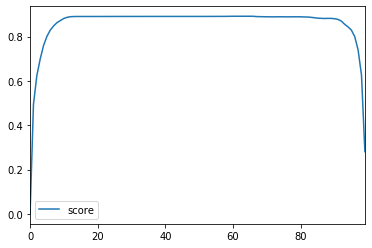

0.63
predicting test set
136459/136459 [==============================] - 5s 39us/step


In [51]:
# loads the best weights saved by the checkpoint
model.load_weights('best_model_mcc_bd.h5')
label_predictions = []

print("finding threshold")
predictions = model.predict(test_X, batch_size=512)
best_threshold = threshold_search(test_y, predictions)['threshold']
print(best_threshold)
print("predicting test set")
pred = model.predict(test_X, batch_size=300, verbose=1)
pred_bool = pred > best_threshold
labels = pred_bool.astype("int32")
label_predictions.append(labels)

In [ ]:
# Based on the results, we can say that a probability value about 0.63 can be classified as a ship crossing panama canal
# within the next 30 days.

In [52]:
# Create a dataset to save the results
first_results = pd.concat([pd.DataFrame(test_y),pd.DataFrame(labels), pd.DataFrame(pred)], axis = 1)


first_results.columns = ['actual', 'pred', 'pred_prob']
first_results.to_csv('Panama_predictions.csv')
first_results.tail()

,actual,pred,pred_prob
136454,0.0,0,0.002095
136455,0.0,0,0.001871
136456,0.0,0,0.001797
136457,0.0,0,0.001790
136458,0.0,0,0.001978


In [56]:
# Accuracy
acc = sum(first_results.pred)/sum(first_results.actual)
print("Accuracy of the model is", acc*100)

# MCC
mcc = matthews_corrcoef(first_results.actual, first_results.pred)
print("MCC of the model is", mcc*100)

Accuracy of the model is 99.7846452029719
MCC of the model is 89.16307315168316


# ROC curve

In [57]:
from sklearn.metrics import roc_curve
y_pred_keras = model.predict(test_X).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_y, pred)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

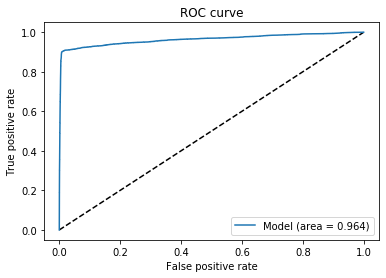

In [58]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Model (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

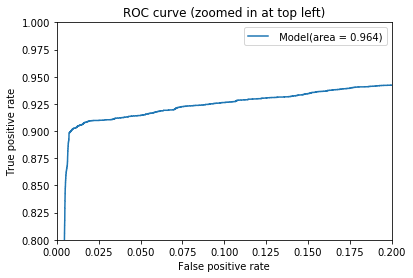

In [59]:
# # Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label=' Model(area = {:.3f})'.format(auc_keras))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

As the classifiers gives a curves closer to the top left corner, it indicated good model performance.

# Confusion matrix

[[126245    927]
 [   947   8340]]


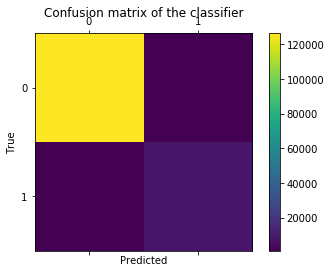

In [69]:
lab = [0, 1]
cm = confusion_matrix(test_y, labels, lab)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + lab)
ax.set_yticklabels([''] + lab)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

The confusion matrix shows the imbalanced nature of the dataset where the non-pass cases are more likely to be classified correctly. 
